In [ ]:
import torch, utils, math
from torch.utils.data import DataLoader, random_split
from datasets import TennesseeEastman

N, K, query_size = 8, 5, 1
train_samples_ratio = 0.1
args = utils.Args(seed=42, N=N, K=K, query_size=query_size, dataset_name='te', in_data_type='seq')
utils.global_manual_seed(seed=args.seed, device=args.device)
split_generator = torch.Generator().manual_seed(args.seed)

te_trainset = TennesseeEastman(root_dir='./data/te', N=N, K=K, query_size=query_size, is_training=True,
                               selected_faults=[i+1 for i in range(N)], seed=args.seed)
te_testset = TennesseeEastman(root_dir='./data/te', N=N, K=K, query_size=query_size, is_training=False,
                              selected_faults=[i+1 for i in range(N)], seed=args.seed)

train_size = math.ceil(train_samples_ratio * len(te_trainset))
test_size = len(te_trainset) - train_size
te_trainset, _ = random_split(te_trainset, [train_size, test_size], generator=split_generator)
print(f"训练数据集大小: {len(te_trainset)}")
print(f"测试数据集大小: {len(te_testset)}")
train_loader = DataLoader(te_trainset, batch_size=1, num_workers=args.num_workers, pin_memory=args.pin_memory)
test_loader = DataLoader(te_testset, batch_size=1, num_workers=args.num_workers, pin_memory=args.pin_memory)

训练数据集大小: 9
测试数据集大小: 83


In [3]:
import nets

cnn1d_num_hidden_channels = 96
lstm_hidden_size = 256
num_cnn1d_out_features = cnn1d_num_hidden_channels*2
cnn1d_embed_size = 128
lstm_embed_size = 128
final_embed_size = 128
cross_class_conv1d_kernel_size = 4
cross_class_conv1d_stride = 4
num_gat_heads = 1
dropout_rate = 0.5 # 8Ways用0.5 16Ways用0.1 对于更大的K选用更大的dropout_rate
cnn1d = nets.AudioCNN1D(num_channels_input=52, 
                        num_channels_hidden=cnn1d_num_hidden_channels,
                        first_kernel_size=8, other_kernel_size=2, stride=4, max_pool_size=2)

lstm = nets.LSTM(input_size=52,
                 hidden_size=lstm_hidden_size,
                 num_layers=3)

ensemble_gcn = nets.EnsembleGCN(num_feature_inputs=(num_cnn1d_out_features, 
                                                    lstm_hidden_size),
                                feature_embed_sizes=(cnn1d_embed_size,
                                                     lstm_embed_size),
                                final_embed_size=final_embed_size,
                                cross_class_conv1d_kernel_size=cross_class_conv1d_kernel_size,
                                cross_class_conv1d_stride=cross_class_conv1d_stride,
                                dropout_rate=dropout_rate,
                                num_classes_output=args.N, query_size=query_size,
                                gat_num_heads=num_gat_heads)

ensemble_net = nets.EnsembleNet(cnn1d=cnn1d,
                                lstm=lstm,
                                ensemble_gcn=ensemble_gcn,
                                in_data_type='seq', dropout_rate=dropout_rate)

Epoch:  1 | Loss: 0.3158368 | Query Acc: 44.44%
Epoch:  2 | Loss: 0.1650744 | Query Acc: 80.56%
Epoch:  3 | Loss: 0.0930362 | Query Acc: 84.72%
Epoch:  4 | Loss: 0.0610645 | Query Acc: 93.06%
Epoch:  5 | Loss: 0.0439239 | Query Acc: 95.83%
Epoch:  6 | Loss: 0.0408879 | Query Acc: 88.89%
Epoch:  7 | Loss: 0.0302483 | Query Acc: 94.44%
Epoch:  8 | Loss: 0.0230925 | Query Acc: 98.61%
Epoch:  9 | Loss: 0.0180706 | Query Acc: 100.00%
Epoch: 10 | Loss: 0.0158152 | Query Acc: 98.61%
Epoch: 11 | Loss: 0.0116181 | Query Acc: 100.00%
Epoch: 12 | Loss: 0.0108097 | Query Acc: 100.00%
Epoch: 13 | Loss: 0.0107924 | Query Acc: 100.00%
Epoch: 14 | Loss: 0.0079275 | Query Acc: 100.00%
Epoch: 15 | Loss: 0.0060376 | Query Acc: 100.00%
Epoch: 16 | Loss: 0.0056428 | Query Acc: 100.00%
Epoch: 17 | Loss: 0.0063522 | Query Acc: 100.00%
Epoch: 18 | Loss: 0.0065911 | Query Acc: 100.00%
Epoch: 19 | Loss: 0.0065457 | Query Acc: 100.00%
Epoch: 20 | Loss: 0.0058286 | Query Acc: 100.00%
Epoch: 21 | Loss: 0.0082587 |

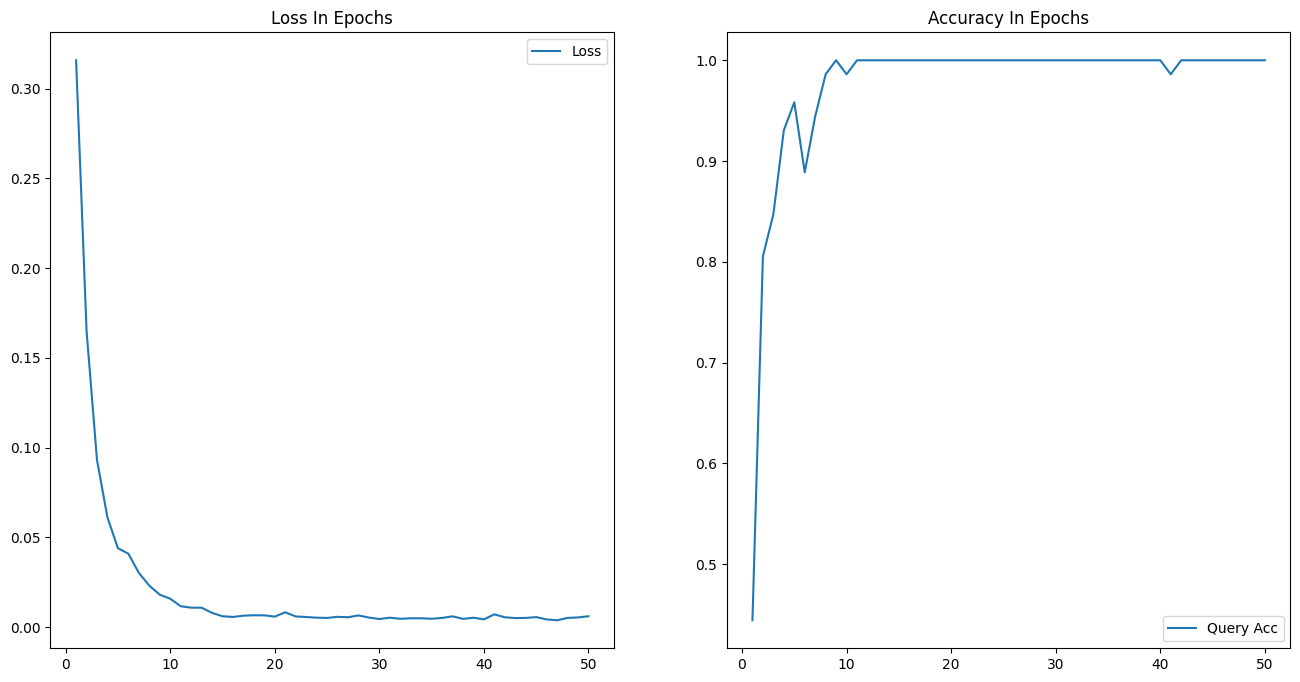

In [4]:
from train_test import train, test

train(ensemble_net, train_loader, args=args,
      num_epochs=50, lr=0.002, weight_decay=0.,
      scheduler_stepsz=10, scheduler_gamma=0.8)

Test Batch   1   |   Query Acc:100.00%
Test Batch   2   |   Query Acc:100.00%
Test Batch   3   |   Query Acc:100.00%
Test Batch   4   |   Query Acc:100.00%
Test Batch   5   |   Query Acc:100.00%
Test Batch   6   |   Query Acc:100.00%
Test Batch   7   |   Query Acc:100.00%
Test Batch   8   |   Query Acc:100.00%
Test Batch   9   |   Query Acc:100.00%
Test Batch  10   |   Query Acc:100.00%
Test Batch  11   |   Query Acc:100.00%
Test Batch  12   |   Query Acc:100.00%
Test Batch  13   |   Query Acc:100.00%
Test Batch  14   |   Query Acc:100.00%
Test Batch  15   |   Query Acc:100.00%
Test Batch  16   |   Query Acc:100.00%
Test Batch  17   |   Query Acc:100.00%
Test Batch  18   |   Query Acc:100.00%
Test Batch  19   |   Query Acc:100.00%
Test Batch  20   |   Query Acc:100.00%
Test Batch  21   |   Query Acc:100.00%
Test Batch  22   |   Query Acc:100.00%
Test Batch  23   |   Query Acc:100.00%
Test Batch  24   |   Query Acc:100.00%
Test Batch  25   |   Query Acc:100.00%
Test Batch  26   |   Quer

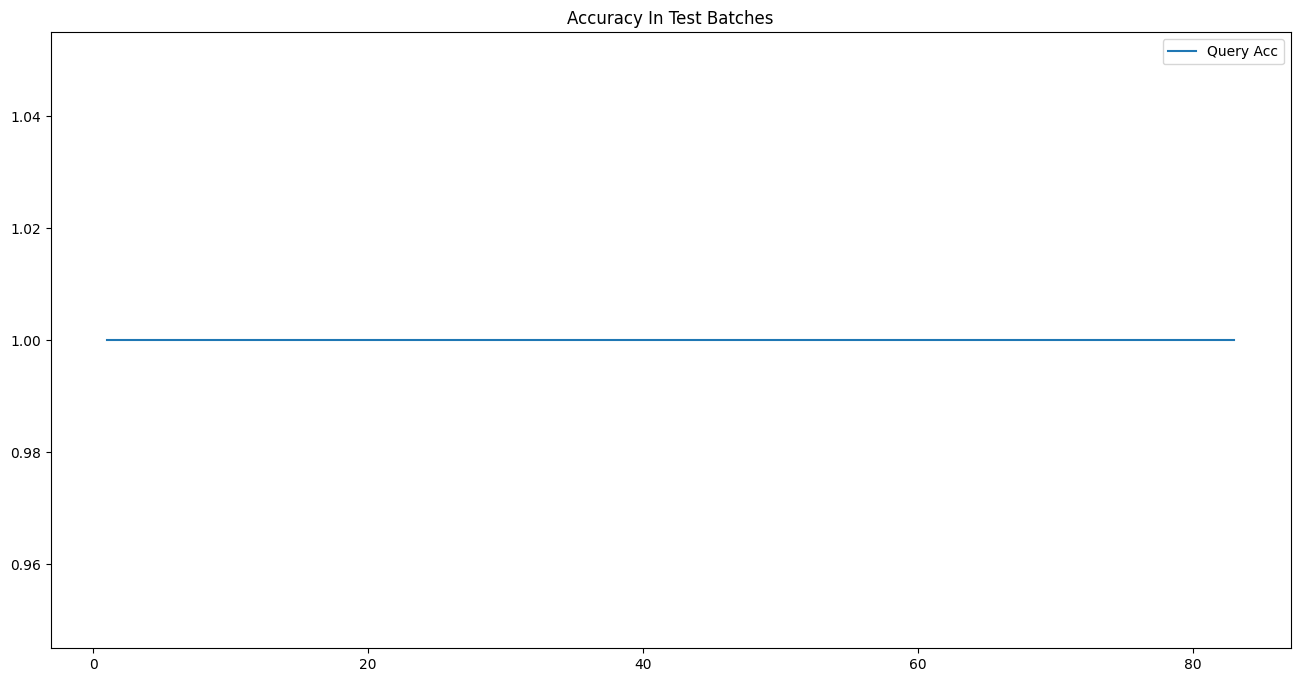

In [5]:
avg_test_acc = test(ensemble_net, test_loader, args)